In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

In [3]:
row_start = 14

In [4]:
metadata = dict()
filename = "1A.CSV"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

{'Model': 'MSO2024B',
 'Firmware Version': '1.56',
 'Point Format': 'Y',
 'Horizontal Units': 'S',
 'Horizontal Scale': '0.4',
 'Sample Interval': '3.2e-05',
 'Filter Frequency': '2e+08',
 'Record Length': '125000',
 'Gating': '0.0% to 100.0%',
 'Probe Attenuation': '1',
 'Vertical Units': 'V',
 'Vertical Offset': '0',
 'Vertical Scale': '2',
 'Label': ''}

In [5]:
data = pd.read_csv(filename, delimiter=",", header=row_start)
data

,TIME,CH1,CH1 Peak Detect,CH2,CH2 Peak Detect
0,-2.00000,9.92,1.008000e+01,9.92,10.00
1,-1.99997,9.92,9.840000e+00,9.92,9.76
2,-1.99994,9.92,1.008000e+01,9.92,10.00
3,-1.99990,9.92,9.840000e+00,9.92,9.76
4,-1.99987,9.92,1.008000e+01,9.92,10.00
...,...,...,...,...,...
124995,1.99984,0.08,-8.583070e-08,0.16,0.08
124996,1.99987,0.08,1.600000e-01,0.16,0.32
124997,1.99990,0.08,-8.583070e-08,0.16,0.08
124998,1.99994,0.08,2.400000e-01,0.16,0.24


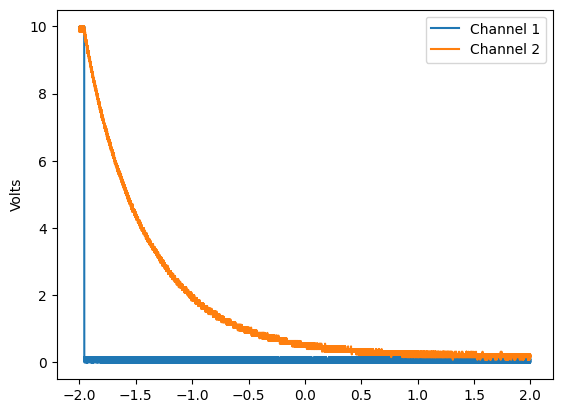

In [6]:
t_raw = data["TIME"]
ch1_raw = data["CH1"]
ch2_raw = data["CH2"]
plt.plot(
    t_raw, 
    ch1_raw,
    label="Channel 1"
)
plt.plot(
    t_raw, 
    ch2_raw,
    label="Channel 2"
)
plt.ylabel("Volts")
plt.legend()

Text(0.5, 1.0, 'Voltage vs. Time')

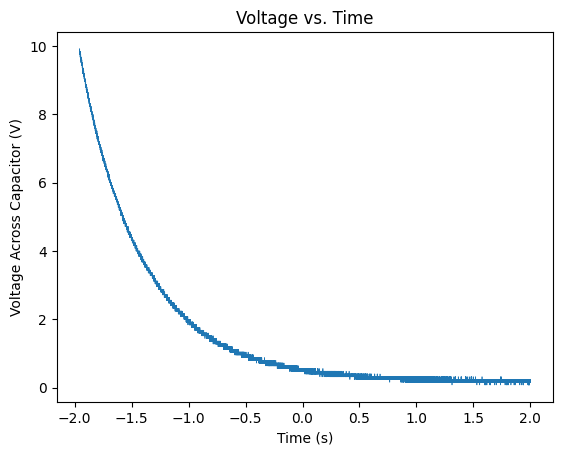

In [44]:
t = t_raw[ch1_raw < 1]
ch2_noisy = ch2_raw[ch1_raw < 1]
plt.plot(t, ch2_noisy, lw=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Voltage Across Capacitor (V)")
plt.title("Voltage vs. Time")

In [8]:
from scipy import signal

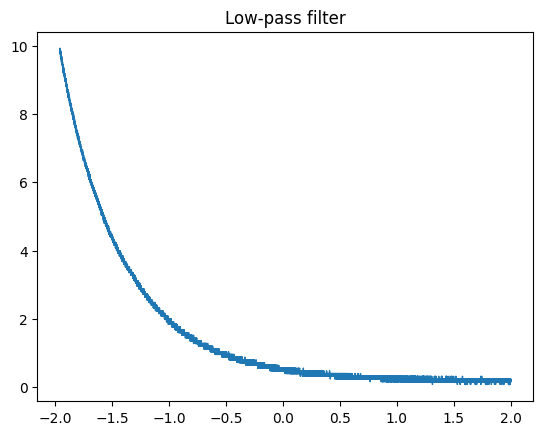

In [28]:
sample_frequency = 2e8
cutoff_frequency = 1e6
b, a = signal.butter(1, 2*cutoff_frequency/sample_frequency)
#ch2 = signal.filtfilt(b, a, ch2_noisy)
ch2 = ch2_noisy
plt.plot(t, ch2, lw=1)
plt.title("Low-pass filter")
plt.show()

In [29]:
model = lambda t, A, RC, z: A * np.exp(-t/RC) + z
[A_model, RC_model, z_model], cov = sp.optimize.curve_fit(model, t, ch2)
cov

array([[ 1.22322990e-08,  7.25674434e-09, -1.31702360e-08],
       [ 7.25674434e-09,  4.39632826e-09, -7.26830903e-09],
       [-1.31702360e-08, -7.26830903e-09,  3.11082270e-08]])

Text(0.5, 1.0, 'Voltage vs. Time')

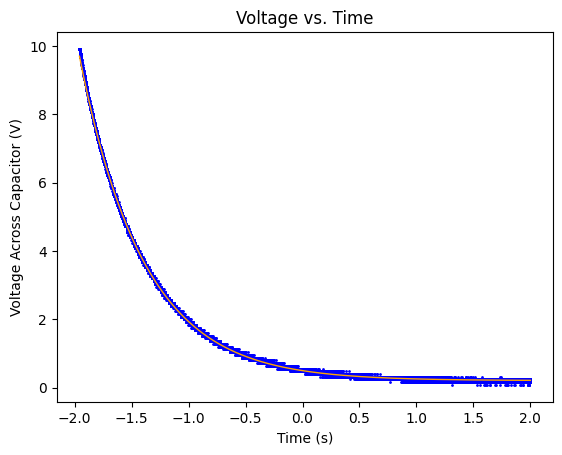

In [60]:
plt.scatter(t, ch2, s=1, color='blue')
plt.plot(t, model(t, A_model, RC_model, z_model), lw=1, color='orange')
plt.xlabel("Time (s)")
plt.ylabel("Voltage Across Capacitor (V)")
plt.title("Voltage vs. Time")

Text(0.5, 1.0, 'Voltage vs. Time Residual')

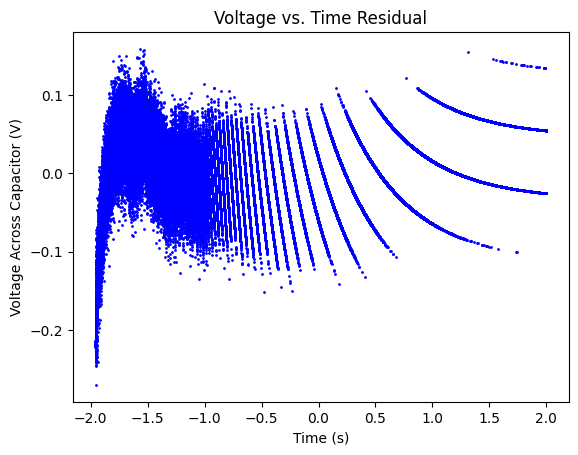

In [62]:
residual = model(t, A_model, RC_model, z_model) - ch2
plt.scatter(t, residual, color='blue', s=1)
plt.xlabel("Time (s)")
plt.ylabel("Voltage Across Capacitor (V)")
plt.title("Voltage vs. Time Residual")

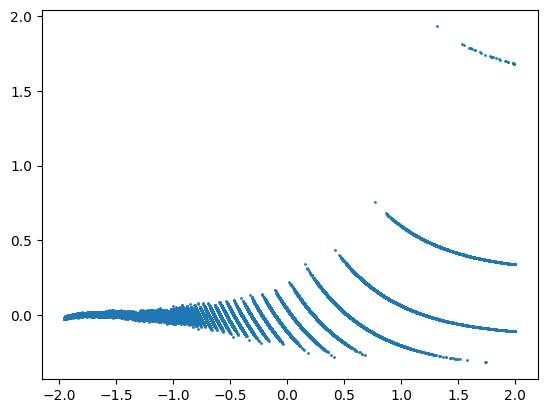

In [64]:
plt.scatter(t, residual / ch2, s=1)

In [33]:
t_truncated = t[t>-1.5]
ch2_truncated = ch2[t>-1.5]
model_truncated = lambda t_truncated, A, RC, z: A * np.exp(-t_truncated/RC) + z
[A_model_truncated, RC_model_truncated, z_model_truncated], cov_truncated = sp.optimize.curve_fit(model_truncated, t_truncated, ch2_truncated)
cov_truncated

array([[ 3.12575177e-08,  2.38878075e-08, -2.30722845e-08],
       [ 2.38878075e-08,  1.89284687e-08, -1.63460153e-08],
       [-2.30722845e-08, -1.63460153e-08,  3.04278995e-08]])

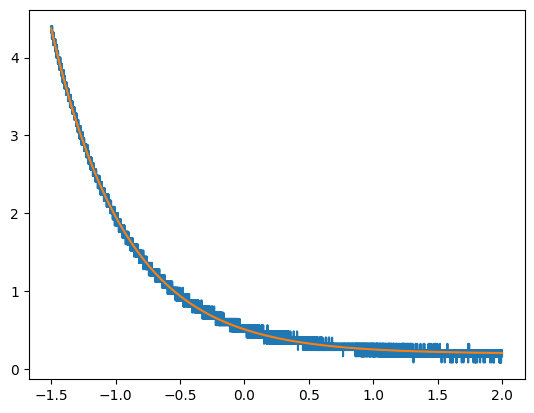

In [34]:
plt.plot(t_truncated, ch2_truncated)
plt.plot(t_truncated, model(t_truncated, A_model_truncated, RC_model_truncated, z_model_truncated))

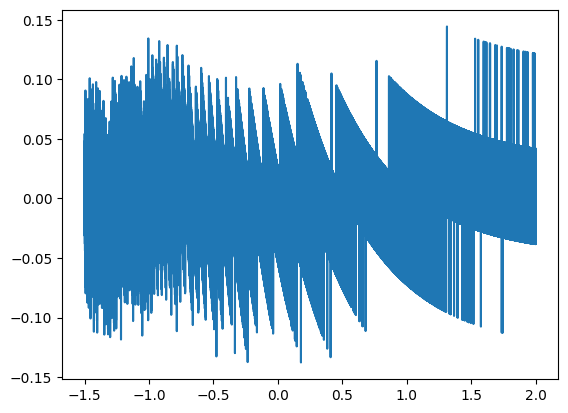

In [35]:
residual_truncated = model_truncated(t_truncated, A_model_truncated, RC_model_truncated, z_model_truncated) - ch2_truncated
plt.plot(t_truncated, residual_truncated)

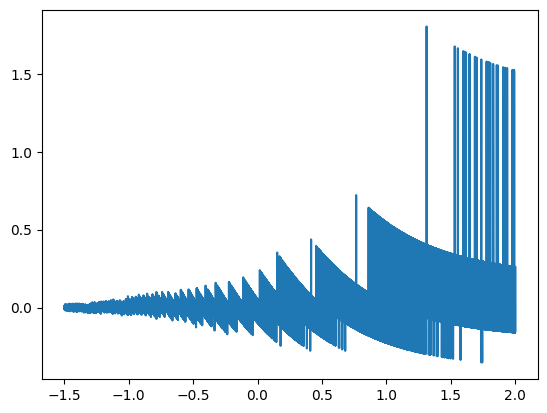

In [36]:
plt.plot(t_truncated, residual_truncated / ch2_truncated)

In [66]:
v_0 = 10
A_error = np.sqrt(cov[0,0]/t.size)
A_error_truncated = np.sqrt(cov_truncated[0,0]/t_truncated.size)
B_error = np.sqrt(cov[1,1]/t.size)
B_error_truncated = np.sqrt(cov_truncated[1,1]/t_truncated.size)
z_error = np.sqrt(cov[2,2]/t.size)
print("A:", A_model / v_0, "+-", A_error / v_0)
print("A-Truncated:", A_model_truncated / v_0, "+-", A_error_truncated / v_0)
print("B:", RC_model, "+-", B_error)
print("B-Truncated:", RC_model_truncated, "+-", B_error_truncated)
print("z:", z_model, "+-", z_error)

A: 0.029208589685208224 +- 3.144830785013284e-08
A-Truncated: 0.031406368866218205 +- 5.3458921779950876e-08
B: 0.562284159066459 +- 1.8853339800611987e-07
B-Truncated: 0.5793181739326909 +- 4.160070527303139e-07
z: 0.20604159694611832 +- 5.015114679702551e-07


In [38]:
chi_squared = ((model(t, A_model, RC_model, z_model) - ch2)**2 / (0.04**2)).sum()
chi_squared_reduced = chi_squared / (t.size - 3)
print(chi_squared_reduced)

1.0572402350213426


In [39]:
chi_squared_truncated = ((model_truncated(t_truncated, A_model_truncated, RC_model_truncated, z_model_truncated) - ch2_truncated)**2 / (0.04**2)).sum()
chi_squared_reduced_truncated = chi_squared_truncated / (t_truncated.size - 3)
print(chi_squared_reduced_truncated)

0.7476855034635982
